<img src="https://drive.google.com/uc?id=1cXtXdAcwedVDbapmz1pj_hULsQrhEcff" width="500"/>


---


# **Diffusion models**

#### **Morning contents/agenda**

1. *Why* use diffusion models?

2. *What* are diffusion models?

3. Score-based models

#### **Learning outcomes**

1. Understand how Diffusion models differ from VAEs and GANs

2. Understand how the forward and reverse diffusion processes work

3. Understand how we can sample from Diffusion models and the importance of noise in their training

<br>

#### **Afternoon contents/agenda**

1. Implement cosine variance schedule

2. Improve the U-Net architecture

#### **Learning outcomes**

1. Understand the impact of the variance schedule on Diffusion models

2. Understand some of the design choices that make Diffusion models feasible in practice

<br/>

---

<br/>

## 1. A different variance schedule

The variance schedule, generally designated by $\{ \beta_t \in (0,1) \}_{t=1}^T$, controls how much noise is added to the data in each step of the forward diffusion. In the morning session, we used a fairly simple linear schedule:

```
betas = torch.linspace(beta_1, beta_T, T)
```

This afternoon, we are going to try implementing a cosine variance schedule, as suggested by [this](https://arxiv.org/abs/2102.09672) paper.

To do this, we will begin with the same implementation for the Diffusion Model that we had this morning. You can copy the implementation from this morning's notebook, but I recommend that you try implementing it from scratch as a good learning excercise.


In [1]:
!pip install pycm livelossplot torchinfo
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary
import torchvision
from torchvision import transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 42.4 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


### **1.1. Dataset preparation**

Let's start by loading the the MNIST dataset and applying some initial processing to the images.

In [3]:
# define torch transformations
img_dim = 32
tf = transforms.Compose([transforms.ToTensor(), # convert to a tensor and normalize to [0,1]
                         transforms.Resize((img_dim, img_dim), antialias=True), # resize images to 32x32 for ease-of-use with the U-Net architecture
                         transforms.Lambda(lambda t: (t * 2) - 1)]) # scale to the range [-1,1]

# download and define MNIST as a torch dataset, using the above transformations
dataset = torchvision.datasets.MNIST("./", download=True, train=True, transform=tf)

# define a torch dataloader with a batch size of 64
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:12<00:00, 825kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.87MB/s]


We can plot a few samples from the dataset to check that everything is as we expect.

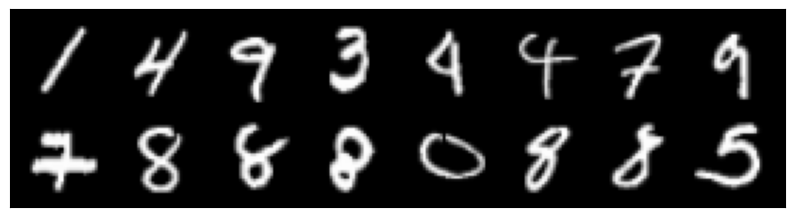

In [4]:
# grab a batch of data and pull out the first 16 images
x0 = next(iter(dataloader))[0][:16]

# define a plotting function to visualize the batch as a grid image
def plot_batch(x):
    """plot batch x as grid image"""

    # re-scale and clamp to the range [0,1]
    x = torch.clamp((x+1)/2, 0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(torchvision.utils.make_grid(x, pad_value=0, padding=2).permute(1, 2, 0))
    plt.xticks([]); plt.yticks([])
    plt.show()

# visualize the batch
plot_batch(x0)

### **1.2. Cosine scheduling**

Next, let's define our cosine scheduling.

According to [the paper](https://arxiv.org/abs/2102.09672), the cosine schedule is defined by:

$$
\bar\alpha_t = \frac{f(t)}{f(0)}
$$

$$
f(t) = \cos\left( \frac{t/T + s}{1 + s} \frac{\pi}{2} \right)^2
$$

$$
\beta_t = 1 - \frac{\bar\alpha_t}{\bar\alpha_{t-1}}
$$

where $s = 0.0081$.

We can now implement these calculations using PyTorch operations:

In [5]:
# set maximum time value
T = 1000
y = torch.linspace(0, T, T + 1)

s = 0.0081
alphas_bar = torch.cos(((y / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
alphas_bar = alphas_bar / alphas_bar[0]
betas = torch.clip(1 - (alphas_bar[1:] / alphas_bar[:-1]), 0.0001, 0.9999)

### **1.3. Forward diffusion process**

As we did this morning, we can now implement the forward diffusion process using our new variance schedule.

Let's start with some utilities for later on:

In [6]:
# pre-calculate other helpful terms that derive from the variance schedule
alphas = 1. - betas
alphas_bar = torch.cumprod(alphas, axis=0)

# define a function to handle the discrepancy between batch vs schedule shapes
def fix_batch(sched, t, device):
    """extract sched at time t, and expand to batch dimensionality"""
    return sched.to(device)[t.to(device)[:,None,None,None]]

Let's now implement the forward diffusion process, where we take a data sample and progressively corrupt it by adding a sequence of Gaussian noise controlled by the variance schedule:

$$
x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon
$$

In [7]:
# let's define a function that implements the forward diffusion process
def forward_diffusion(x0, t, e):
    """run the forward diffusion process on x up to time t using noise e"""
    sqrt_alphas = fix_batch(torch.sqrt(alphas_bar), t, x0.device)
    sqrt_alphas_minus_one = fix_batch(torch.sqrt(1. - alphas_bar), t, x0.device)

    return sqrt_alphas*x0 + sqrt_alphas_minus_one*e

Let's test the forward diffusion process out on our current batch $x_{0}$.

In [8]:
# sample 16 values for t that are evenly spaced from t=0 to t=T
t = torch.linspace(0, T-1, len(x0), dtype=torch.long)

# draw a random sample from a normal distribution with unit variance
e = torch.randn_like(x0)

# calculate the forward diffusion process for a single image from batch x0
x_t = forward_diffusion(x0[0], t, e)

And do some plotting of the effect of the schedule on the images and histograms.

tensor([  0,  66, 133, 199, 266, 333, 399, 466, 532, 599, 666, 732, 799, 865,
        932, 999])


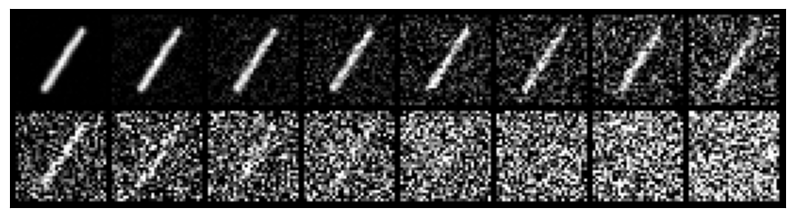

In [9]:
# display t values and visualize the forward diffusion process
print(t)
plot_batch(x_t)

/tmp/ipython-input-449190636.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  plt.hist(x_t[i].flatten(), bins=np.arange(x_t[-1].min(), x_t[-1].max() + 0.5, 0.5), edgecolor='black', linewidth=1.2)


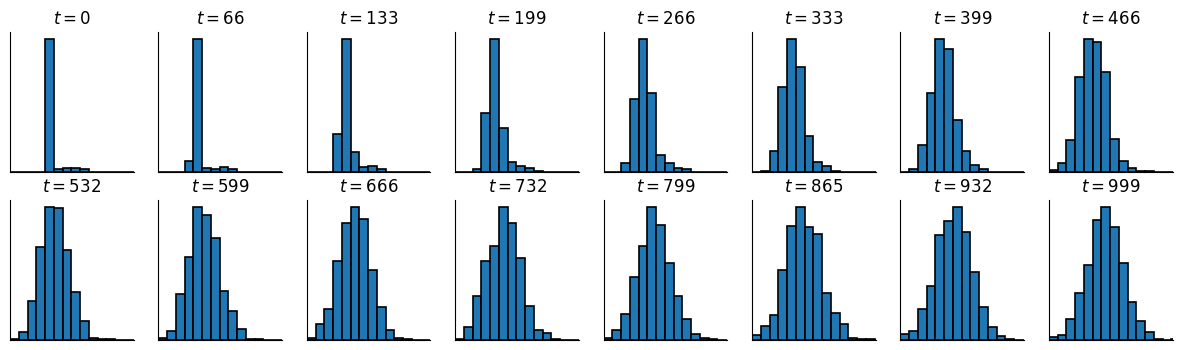

In [10]:
# display histograms of the pixel values throughout the forward diffusion
plt.figure(figsize=(15, 4))
for i in range(len(t)):
    plt.subplot(2, len(t)//2, 1+i)
    plt.hist(x_t[i].flatten(), bins=np.arange(x_t[-1].min(), x_t[-1].max() + 0.5, 0.5), edgecolor='black', linewidth=1.2)
    plt.xlim(x_t[-1].min(), x_t[-1].max())
    plt.xticks([]); plt.yticks([])
    plt.title(f'$t={t[i]}$')
    sns.despine()

**Consider:** Do you see any differences with respect to the linear schedule that we used this morning?

The forward diffusion using the linear variance schedules arrives at an entirely noise corrupted sample *significantly before* $t=T$. Due to their high noise, these time steps do not contribute much to the quality of the reverse diffusion process. The forward diffusion with the cosine schedule appears to more evenly corrupt the samples during the over $t=0$ to $t=T$.

### **1.4. Building the Diffusion model**

We will use the same network definition from this morning.

Let's start by defining the position embeddings:

In [11]:
# define the sinusoidal position embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    """sinusoidal position embedding, https://arxiv.org/abs/1706.03762"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

This embedding is often passed through a small multi-layered perceptron (or fully connected network), and is then added to each convolutional block throughout the U-Net.

Let's create a `ConvBlock` that will apply a series of operations:

- 2D convolution on input
- linear operation on position embedding
- batch normalisation
- SiLU activation function

We will then use this `ConvBlock` to creating an encoding `EncBlock` and a decoding `DecBlock`:

- `EncBlock` will apply two `ConvBlock`, followed by a max pooling operation.
- `DecBlock` will apply a transposed convolution, followed by two `ConvBlock`. `DecBlock` will also include a skip connection from the encoder.

In [12]:
# define a convolutional block with time-embedding
class ConvBlock(nn.Module):
    """time-conditioned convolutional block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.dense = nn.Linear(embed_dim, out_c) # reshapes the time embedding length to the number of channels
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU()

    def forward(self, x, t_embed):
        x = self.conv(x)
        x += self.dense(t_embed)[...,None,None] # add the output of the time embedding dense layer
        x = self.bn(x)
        x = self.act(x)
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):
    """time-conditioned U-Net encoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x, t_embed):
        h = self.conv_block1(x, t_embed)
        h = self.conv_block2(h, t_embed)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):
    """time-conditioned U-Net decoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)

    def forward(self, x, s, t_embed):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h, t_embed)
        h = self.conv_block2(h, t_embed)
        return h

Putting it all together, we can now define our time-conditioned U-Net!

In [13]:
class Unet(nn.Module):
    """DDPM U-Net, https://arxiv.org/abs/2006.11239 and https://arxiv.org/abs/1505.04597"""

    def __init__(self, n_channels, embed_dim):
        super().__init__()

        # time positional embedding MLP
        self.embed = nn.Sequential(SinusoidalPositionEmbeddings(embed_dim),
                                   nn.Linear(embed_dim, embed_dim),
                                   nn.GELU(),
                                   nn.Linear(embed_dim, embed_dim))

        # encoder
        self.e1 = EncBlock(n_channels, 64, embed_dim)
        self.e2 = EncBlock(64, 128, embed_dim)
        self.e3 = EncBlock(128, 256, embed_dim)
        self.e4 = EncBlock(256, 512, embed_dim)

        # bottleneck
        self.b1 = ConvBlock(512, 1024, embed_dim)
        self.b2 = ConvBlock(1024, 1024, embed_dim)

        # decoder
        self.d1 = DecBlock(1024, 512, embed_dim)
        self.d2 = DecBlock(512, 256, embed_dim)
        self.d3 = DecBlock(256, 128, embed_dim)
        self.d4 = DecBlock(128, 64, embed_dim)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x, t):

        t_embed = self.embed(t)

        # encoder
        s1, x = self.e1(x, t_embed)
        s2, x = self.e2(x, t_embed)
        s3, x = self.e3(x, t_embed)
        s4, x = self.e4(x, t_embed)

        # bottleneck
        x = self.b1(x, t_embed)
        x = self.b2(x, t_embed)

        # decoder
        x = self.d1(x, s4, t_embed)
        x = self.d2(x, s3, t_embed)
        x = self.d3(x, s2, t_embed)
        x = self.d4(x, s1, t_embed)

        # output
        output = self.output(x)

        return output

### **1.5. Model training**

To train the network, we will use the following procedure:

1. Randomly select a sample from the training data $x_{0}$

2. Randomly sample $t$ from a uniform distribution over the range $[1,T]$

3. Randomly sample $\epsilon$ from a zero-mean normal distribution with a variance of 1

4. Apply the forward diffusion process on $x_{0}$ using $\epsilon$ and $t$

5. Predict the noise by evaluating $\epsilon_{\theta}(x_{t}, t)$

6. Calculate the MSE loss between the true noise $\epsilon$ and the predicted noise $\epsilon_{\theta}(x_{t}, t)$

7. Take a gradient descent (or Adam) step with respect to the model parameters $\theta$

8. Repeat steps 1 to 7 until converged

These steps are performed batch-wise in practice.

Let's start by instantiating our model, optimizer and criterion:

In [14]:
# define the model and send to the GPU
model = Unet(1, img_dim*4).to(device)

# specify the Adam optimizer with a learning rate of 2e-4
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

# set the criterion to be the mse loss
criterion = F.mse_loss

Next, let's build our training loop following the steps above:

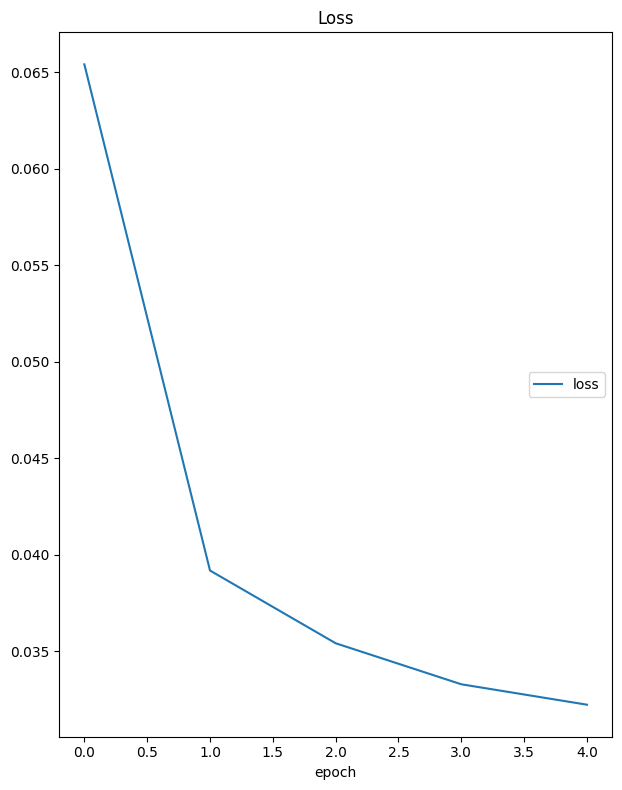

Loss
	loss             	 (min:    0.032, max:    0.065, cur:    0.032)


In [15]:
# ensure model is in training mode
model.train()

# set number of epochs and loop over them
n_epoch = 5

# Set up liveloss plot
liveloss = PlotLosses()

for epoch in range(n_epoch):

    # loop over each batch using tqdm to report progress and loss stats
    pbar = tqdm(dataloader)
    tot_loss = 0
    logs = {}
    for x0, _ in pbar:

        # zero the gradients
        opt.zero_grad()

        # send the batch to the GPU
        x0 = x0.to(device)

        # sample t from a uniform distribution
        t = torch.randint(0, T, (x0.shape[0],), dtype=torch.long).to(x0.device)

        # sample e from a normal distribution
        e = torch.randn_like(x0)

        # run the forward diffusion process to add noise to x0
        x_t = forward_diffusion(x0, t, e)

        # calculate the loss between the predicted noise and the true noise
        loss = criterion(model(x_t, t), e)

        # backpropagation to obtain gradients w.r.t model parameters
        loss.backward()

        # Report current loss using tqdm
        tot_loss += loss.item()
        pbar.set_description(f"loss: {loss.item():.4f}")

        # take an optimisation step
        opt.step()

    logs['loss'] = tot_loss / len(dataloader)
    liveloss.update(logs)
    liveloss.draw()

### **Reverse diffusion**

With a trained model, let's sample from it!

We'll start by implementing the reverse diffusion process:

In [16]:
# let's define a function that implements the reverse diffusion process
def reverse_diffusion(x, t, e, z):
    """run the reverse diffusion process"""
    sigma = fix_batch(torch.sqrt(betas), t, x.device)
    sqrt_recip_alphas = fix_batch(torch.sqrt(1.0 / alphas), t, x.device)
    scale = fix_batch((1 - alphas) / torch.sqrt(1. - alphas_bar), t, x.device)

    return sqrt_recip_alphas * (x - scale*e) + sigma*z

The sampling process then will be:

1. Randomly sample $x_{T}$ from a zero-mean normal distribution with a variance of 1

2. If $t>0$, randomly sample $z$ from a zero-mean normal distribution with a variance of 1, otherwise set $z=0$

3. Calculate the updated sample $x_{t-1}$ by subtracting the predicted noise $\epsilon_{\theta}(x_{t}, t)$ from $x_{t}$

4. Apply $z$, scaled by $\sigma_{t}$, to the sample

5. Repeat steps 2 to 4 for $t=T,\dots,1$

In [17]:
# ensure model is in evaluation mode
model.eval()

# randomly sample an xT batch from a normal distribution
x = torch.randn_like(next(iter(dataloader))[0])

# send to the GPU and only consider first 16 of the batch to ease the computational burden
x = x.to(device)[:16]

# container to store sample throughout the reverse diffusion
diffusion = torch.empty((T, x.shape[0], x.shape[1], x.shape[2], x.shape[3])).to(x.device)

# context management to ensure gradients are not tracked for any torch tensors or parameters
with torch.no_grad():

    # loop over time from T to 0
    for t in reversed(range(0,T)):

        # sample z from a normal distribution if condition met
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0

        # visualize samples x every 100 iterations
        if t % 50 == 0:
            print(f'samples at t={t}')
            plot_batch(x.cpu())

        # convert t to a tensor, send to the GPU, and expand its first dimension to be equal to batch size
        t = torch.tensor(t).to(device).expand(x.shape[0])

        # denoise x
        x = reverse_diffusion(x, t, model(x, t), z)

        # clipping to ensure the sample values remain in the range -1 to 1
        x = torch.clamp(x, -1, 1)

        # store the current samples x
        diffusion[t] = x

Output hidden; open in https://colab.research.google.com to view.

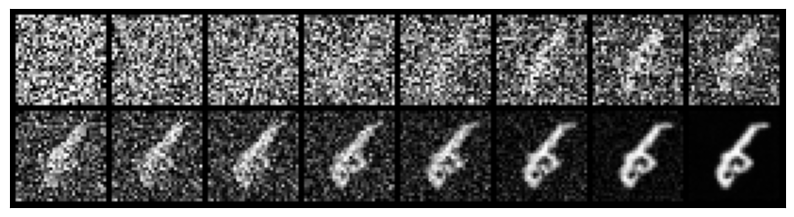

In [18]:
# visualize the diffusion process for a single sample
plot_batch(diffusion[::66,0].flip(0).cpu())

<br>

---

<br>

## 2. Fine-tuning our model

We are going to make some changes to the model above to squeeze out some performance improvements.

Under **appendix B** of the DDPM paper, it states that they use a modified U-Net with [group normalisation](https://arxiv.org/abs/1803.08494). So, first we are going to replace batch normalisation with group normalisation.

**Consider:** Why do you think group normalisation might be more suitable than batch normalisation for the DDPM model?

<br>

Under **appendix B** of the DDPM paper, it states that they use [residual](https://arxiv.org/abs/1512.03385) blocks in the downsampling and upsampling paths of the U-Net. We are also going to incorporate residual connections into the encoder and decoder blocks.

**Consider:** Why do you think residual connections might have an impact in this case?

<br>

You may also notice that the DDPM model uses the [attention](https://arxiv.org/abs/1706.03762) mechanism used by Transformers. We will not be implementing attention today.

### **2.1. Updated diffusion model**

Let's make the necessary changes to our `ConvBlock`, `EncBlock` and `DecBlock`.

In [19]:
# define a convolutional block with time-embedding
class ConvBlock(nn.Module):
    """time-conditioned convolutional block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.dense = nn.Linear(embed_dim, out_c) # reshapes the time embedding length to the number of channels
        self.gn = nn.GroupNorm(8, out_c) # group normalisation
        self.act = nn.SiLU()

    def forward(self, x, t_embed):
        x = self.conv(x)
        x += self.dense(t_embed)[...,None,None] # add the output of the time embedding dense layer
        x = self.gn(x) # group normalisation
        x = self.act(x)
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):
    """time-conditioned U-Net encoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)
        self.res = nn.Conv2d(in_c, out_c, 1) # add a convolutional layer to handle skip connection dimensionality
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x, t_embed):
        h = self.conv_block1(x, t_embed)
        h = self.conv_block2(h, t_embed)
        h += self.res(x) # residual block skip connection
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):
    """time-conditioned U-Net decoder block"""

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c, embed_dim)
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim)

    def forward(self, x, s, t_embed):
        x = self.up(x)
        h = torch.cat([x, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h, t_embed)
        h = self.conv_block2(h, t_embed)
        return h + x # residual block skip connection

Putting it all together, we can now define our time-conditioned U-Net!

In [20]:
class Unet(nn.Module):
    """DDPM U-Net, https://arxiv.org/abs/2006.11239 and https://arxiv.org/abs/1505.04597"""

    def __init__(self, n_channels, embed_dim):
        super().__init__()

        # time positional embedding MLP
        self.embed = nn.Sequential(SinusoidalPositionEmbeddings(embed_dim),
                                   nn.Linear(embed_dim, embed_dim),
                                   nn.GELU(),
                                   nn.Linear(embed_dim, embed_dim))

        # encoder
        self.e1 = EncBlock(n_channels, 64, embed_dim)
        self.e2 = EncBlock(64, 128, embed_dim)
        self.e3 = EncBlock(128, 256, embed_dim)
        self.e4 = EncBlock(256, 512, embed_dim)

        # bottleneck
        self.b1 = ConvBlock(512, 1024, embed_dim)
        self.b2 = ConvBlock(1024, 1024, embed_dim)

        # decoder
        self.d1 = DecBlock(1024, 512, embed_dim)
        self.d2 = DecBlock(512, 256, embed_dim)
        self.d3 = DecBlock(256, 128, embed_dim)
        self.d4 = DecBlock(128, 64, embed_dim)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x, t):

        t_embed = self.embed(t)

        # encoder
        s1, x = self.e1(x, t_embed)
        s2, x = self.e2(x, t_embed)
        s3, x = self.e3(x, t_embed)
        s4, x = self.e4(x, t_embed)

        # bottleneck
        x = self.b1(x, t_embed)
        x = self.b2(x, t_embed)

        # decoder
        x = self.d1(x, s4, t_embed)
        x = self.d2(x, s3, t_embed)
        x = self.d3(x, s2, t_embed)
        x = self.d4(x, s1, t_embed)

        # output
        output = self.output(x)

        return output

### **2.2. Model training**

To train the network, we will use the following procedure:

1. Randomly select a sample from the training data $x_{0}$

2. Randomly sample $t$ from a uniform distribution over the range $[1,T]$

3. Randomly sample $\epsilon$ from a zero-mean normal distribution with a variance of 1

4. Apply the forward diffusion process on $x_{0}$ using $\epsilon$ and $t$

5. Predict the noise by evaluating $\epsilon_{\theta}(x_{t}, t)$

6. Calculate the MSE loss between the true noise $\epsilon$ and the predicted noise $\epsilon_{\theta}(x_{t}, t)$

7. Take a gradient descent (or Adam) step with respect to the model parameters $\theta$

8. Repeat steps 1 to 7 until converged

These steps are performed batch-wise in practice.

Let's start by instantiating our model, optimizer and criterion:

In [21]:
# define the model and send to the GPU
model = Unet(1, img_dim*4).to(device)

# specify the Adam optimizer with a learning rate of 2e-4 (see appendix B)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)

# set the criterion to be the mse loss
criterion = F.mse_loss

Now, let's build our training loop again:

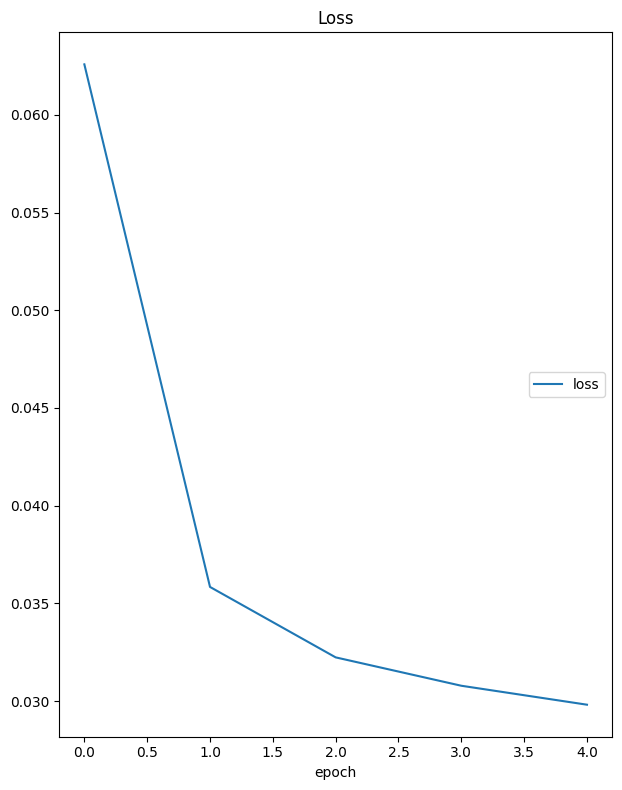

Loss
	loss             	 (min:    0.030, max:    0.063, cur:    0.030)


In [22]:
# ensure model is in training mode
model.train()

# set number of epochs and loop over them
n_epoch = 5

# Set up liveloss plot
liveloss = PlotLosses()

for epoch in range(n_epoch):

    # loop over each batch using tqdm to report progress and loss stats
    pbar = tqdm(dataloader)
    tot_loss = 0
    logs = {}
    for x0, _ in pbar:

        # zero the gradients
        opt.zero_grad()

        # send the batch to the GPU
        x0 = x0.to(device)

        # sample t from a uniform distribution
        t = torch.randint(0, T, (x0.shape[0],), dtype=torch.long).to(x0.device)

        # sample e from a normal distribution
        e = torch.randn_like(x0)

        # run the forward diffusion process to add noise to x0
        x_t = forward_diffusion(x0, t, e)

        # calculate the loss between the predicted noise and the true noise
        loss = criterion(model(x_t, t), e)

        # backpropagation to obtain gradients w.r.t model parameters
        loss.backward()

        # Report current loss using tqdm
        tot_loss += loss.item()
        pbar.set_description(f"loss: {loss.item():.4f}")

        # take an optimisation step
        opt.step()

    logs['loss'] = tot_loss / len(dataloader)
    liveloss.update(logs)
    liveloss.draw()

### **2.3. Reverse diffusion**

Let's implement the reverse diffusion process again:

In [23]:
# let's define a function that implements the reverse diffusion process
def reverse_diffusion(x, t, e, z):
    """run the reverse diffusion process"""
    sigma = fix_batch(torch.sqrt(betas), t, x.device)
    sqrt_recip_alphas = fix_batch(torch.sqrt(1.0 / alphas), t, x.device)
    scale = fix_batch((1 - alphas) / torch.sqrt(1. - alphas_bar), t, x.device)

    return sqrt_recip_alphas * (x - scale*e) + sigma*z

The sampling process then will be:

1. Randomly sample $x_{T}$ from a zero-mean normal distribution with a variance of 1

2. If $t>0$, randomly sample $z$ from a zero-mean normal distribution with a variance of 1, otherwise set $z=0$

3. Calculate the updated sample $x_{t-1}$ by subtracting the predicted noise $\epsilon_{\theta}(x_{t}, t)$ from $x_{t}$

4. Apply $z$, scaled by $\sigma_{t}$, to the sample

5. Repeat steps 2 to 4 for $t=T,\dots,1$

In [24]:
# ensure model is in evaluation mode
model.eval()

# randomly sample an xT batch from a normal distribution
x = torch.randn_like(next(iter(dataloader))[0])

# send to the GPU and only consider first 16 of the batch to ease the computational burden
x = x.to(device)[:16]

# container to store sample throughout the reverse diffusion
diffusion = torch.empty((T, x.shape[0], x.shape[1], x.shape[2], x.shape[3])).to(x.device)

# context management to ensure gradients are not tracked for any torch tensors or parameters
with torch.no_grad():

    # loop over time from T to 0
    for t in reversed(range(0,T)):

        # sample z from a normal distribution if condition met
        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0

        # visualize samples x every 100 iterations
        if t % 50 == 0:
            print(f'samples at t={t}')
            plot_batch(x.cpu())

        # convert t to a tensor, send to the GPU, and expand its first dimension to be equal to batch size
        t = torch.tensor(t).to(device).expand(x.shape[0])

        # denoise x
        x = reverse_diffusion(x, t, model(x, t), z)

        # clipping to ensure the sample values remain in the range -1 to 1
        x = torch.clamp(x, -1, 1)

        # store the current samples x
        diffusion[t] = x

Output hidden; open in https://colab.research.google.com to view.

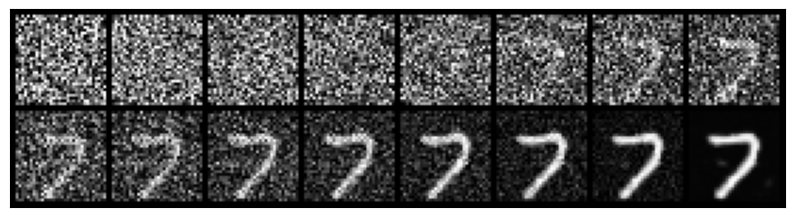

In [25]:
# visualize the diffusion process for a single sample
plot_batch(diffusion[::66,0].flip(0).cpu())



---



## 3. Stable diffusion demo

[Stable diffusion](https://github.com/CompVis/stable-diffusion) is an open-source pre-trained text-to-image model based on the latent diffusion model presented in [this](https://arxiv.org/abs/2112.10752) paper.

Feel free to play with this pre-trained model to see how powerful Diffusion Models can be.

---

<br>
<center>
⚠

<br>

Do not burn through all of your Google colab compute units!

⚠

<br>

---

#### **3.1. Configuration**

In [26]:
# install necessary libraries
!pip install --quiet --upgrade diffusers transformers scipy mediapy accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.9 MB/s eta 0:00:00


*You may need to restart your kernel for the accelerate library installation to work correctly.*

**Step 1.** You will need a hugging face account to be able to access and download the stable diffusion model weights.

<br>

**Step 2.** Once you have an account, you will need to generate a token to login. Execute the following cell and enter your token.

<br>

In [27]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `token_2` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-crede

**Step 3.** Visit the [card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for the stable diffusion v1-4 model we will be using today, read license and tick the check box if you agree.

<br>

#### **3.2. Imports**

In [28]:
from diffusers import PNDMScheduler
from diffusers import StableDiffusionPipeline
import mediapy as media
import torch

#### **3.3. Variance schedule**

There are multiple proposed variance schedules that can be used with pre-trained diffusion models such as Stable diffusion. We will use the [PNDM](https://arxiv.org/abs/2202.09778) scheduler here, but there are many other suitable alternatives.

In [29]:
# define the PNDM scheduler
scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True, steps_offset=1)

In [30]:
# load the pre-trained stable diffusion model pipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=scheduler,
                                               torch_dtype=torch.float16, variant="fp16", use_auth_token=True)

# send pipeline to the GPU
pipe.to("cuda")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

safety_checker/model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [31]:
# define a text prompt
prompt = "A sausage dog walking through Imperial College London"

# generate multiple images from the same text prompt
num_images = 4
prompts = [prompt] * num_images

# run the reverse diffusion
images = pipe(prompts, guidance_scale=8, num_inference_steps=50).images

  0%|          | 0/50 [00:00<?, ?it/s]

,,,

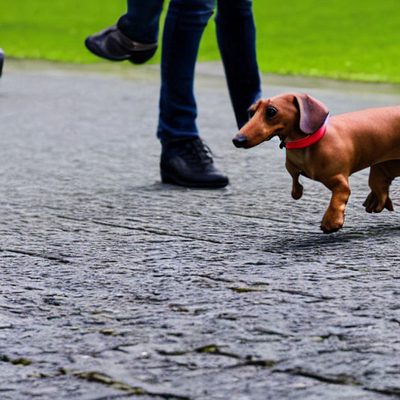
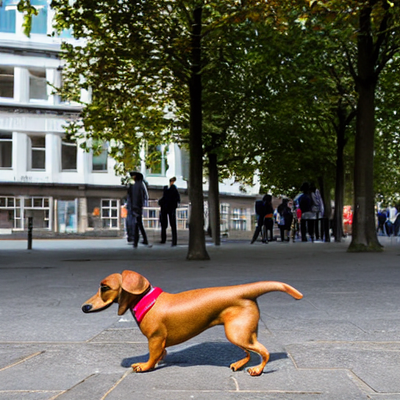
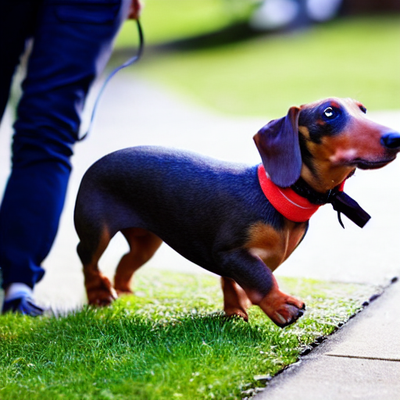
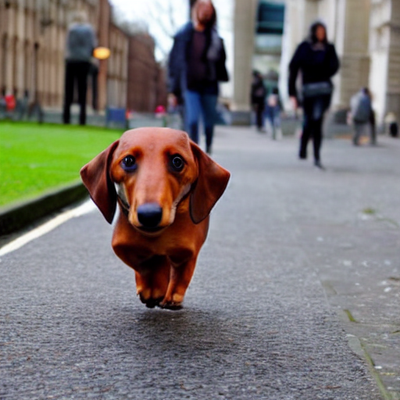

In [32]:
media.show_images(images, height=400)

<br>

---

<br>